# Texture Synthesis with Spatial Generative Adversarial Networks

[Paper](https://arxiv.org/pdf/1611.08207v2.pdf)
[Sample implementation](https://github.com/ubergmann/spatial_gan)


### Model Summary

This is a fully-convolutional "spatial" variant of a *deep convolutional generative adversarial network*.

The **generator** takes a 4x4x16 tensor of random uniform noise (from -1 to 1) and returns a 128x128 RGB image by upscaling via 5 resize-convolutional layers (2x bicubic resampling followed by 3x3 convolution, relu and batch-norm). The last layer has a sigmoid instead of relu and batch-norm.

The **discriminator** transforms the image into a 4x4x2 image using 5 layers of 3x3 convolution and average-pooling, followed by (in all but the final layer) leaky relu (a=0.2) and batch normalization.

Convolution weights use xavier initialization, and biases are initialized to 0.1.

The loss function is softmax cross-entropy, learning rate 0.0002 for the discriminator and 0.0004 for the generator, using the Adam optimizer (beta1=0.5). The discriminator isn't trained while its accuracy is above 0.85.

In addition to discriminating between current samples from the generator, the discriminator is fed batches of random previously-generated samples.

### Ideas for improvements

Expand the convolutional filter size on the discriminator *or* generator — see if this improves tiled texture quality by giving the model a broader view of the data.

Try bringing back concat-relu and concat-lrelu activations functions. (update: this doesn't seem to work too well.)

In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io
import random

In [2]:
BATCH_SIZE = 16
Z_WIDTH, Z_HEIGHT = (4, 4)
OUTPUT_WIDTH, OUTPUT_HEIGHT = (128, 128)
Z_DEPTH = 16
EPOCH_ITERS = 64 * 100
L2_REG = 1e-5

use_resize_conv = True
use_concatenated_activations = False


(660, 1024, 3)


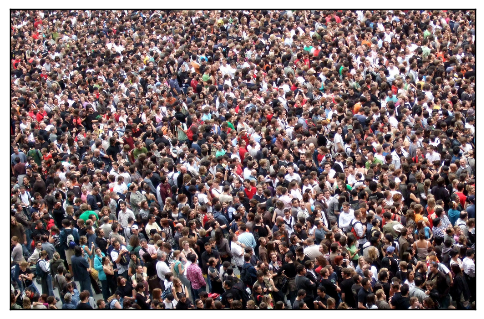

In [13]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/crowd.jpg')
print image.shape
# to_pil(image)
imshow_multi([image])

In [4]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.2
    return tf.maximum(alpha*x, x)

relu = tf.nn.relu

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def concat_lrelu(x):
    axis = len(x.get_shape())-1
    return lrelu(tf.concat(axis, [x, -x]))

def concat_relu(x):
    axis = len(x.get_shape())-1
    return tf.nn.relu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

# conv_init =  lambda shape, dtype, partition_info: np.random.rand(*shape) * 0.1
# zero_init = lambda shape, dtype, partition_info: np.random.rand(*shape) * 0

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

bias_init = tf.truncated_normal_initializer(0.1, 0.0)

def create_conv(input, out_channels, patch_size=5, stride=1, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b


In [5]:
source_image = tf.constant(image, tf.float32)
def rand_crop(): return tf.random_crop(source_image, [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3])

real_textures = tf.pack([rand_crop() for _ in xrange(BATCH_SIZE * 2)])

old_fakes = tf.placeholder_with_default(
    tf.zeros([BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]), 
    [BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3], 
    name='old_fakes')

old_fakes = tf.placeholder(tf.float32, [BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3], name='old_fakes')

def generator(image, name='generator', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        layers = [256, 128, 64, 64, 3]
        for i, channels in enumerate(layers):
            is_last = (i == len(layers)-1)
            
            if use_resize_conv:
                _,w,h,_ = image.get_shape()
                image = tf.image.resize_bilinear(image, [w.value*2, h.value*2])
                image = create_conv(image, channels, patch_size=3, stride=1, name='resize_conv'+str(i))
            else:
                image = create_deconv(image, channels, patch_size=6, stride=2, name='deconv'+str(i))
            
            if not is_last:
                image = concat_relu(image) if use_concatenated_activations else relu(image)
                image = create_batch_norm(image, name='bn'+str(i))
                # image = relu(image)
        print image.get_shape()
        return tf.nn.sigmoid(image)

def discriminator(textures, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        activations = []
        image = textures
        # some big convolutional layers:
        layers = [128, 64, 64, 32, 2]
        for i, channels in enumerate(layers):
            activations.append(image)
            is_last_layer = i == len(layers) - 1
            image = create_conv(image, channels, stride=1, patch_size=3, name='conv'+str(i))
            image = create_avg_pool(image)
            if not is_last_layer:
                image = concat_lrelu(image) if use_concatenated_activations else lrelu(image)
                image = create_batch_norm(image, name='bn'+str(i))  
        # a couple 1x1 convolutions:
        # for i, channels in enumerate([2]):
        #     image = create_conv(image, channels, stride=1, patch_size=1, name='1x1conv'+str(i))
        assert [d.value for d in image.get_shape()[1:]] == [Z_WIDTH, Z_HEIGHT, 2]
        return image, activations

def compute_disc_output_accuracy(output, target):
    disc_guess = tf.argmax(output, 3)
    disc_guess = tf.cast(disc_guess, tf.int32)
    disc_correct = tf.equal(disc_guess, target)
    disc_accuracy = tf.reduce_mean(tf.cast(disc_correct, tf.float32))
    return disc_accuracy

def compute_disc_loss(output, target):
    targets = tf.one_hot(target, depth=2, on_value=0.9)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, targets))

scopename = '36'

disc_lr = tf.placeholder_with_default(tf.constant(0.0002), [], name='disc_lr')
gen_lr = tf.placeholder_with_default(tf.constant(0.0004), [], name='gen_lr')

with tf.variable_scope(scopename):

    noise = tf.random_uniform([BATCH_SIZE, Z_WIDTH, Z_HEIGHT, Z_DEPTH], minval=-1, maxval=1)
    synthetic_textures = generator(noise)
    
    # are_synthetic_textures_real, layer_activations_synth = discriminator(synthetic_textures)
    # are_real_textures_real, layer_activations_real = discriminator(real_textures, reuse=True)
    
#     feature_matching_loss = tf.add_n(
#         [tf.nn.l2_loss(tf.reduce_mean(layer_activations_real[l], 0) - tf.reduce_mean(layer_activations_synth[l], 0)) * 0.1 
#          for l in [0, -2]]
#     )
    
    batch_is_real = tf.ones([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)
    batch_is_fake = tf.zeros_like(batch_is_real)
    
#     sets = [(are_synthetic_textures_real, batch_is_fake),
#             (are_real_textures_real, batch_is_real)]
#             # (are_old_synthetics_real, batch_is_fake)]
    
#     disc_loss = tf.add_n([compute_disc_loss(outputs, labels) for outputs, labels in sets]) / len(sets)
#     disc_acc = tf.add_n([compute_disc_output_accuracy(outputs, labels) for outputs, labels in sets]) / len(sets)
    
    # gen_loss = compute_disc_loss(are_synthetic_textures_real, batch_is_real) + feature_matching_loss
    
    disc_input = tf.concat(0, [synthetic_textures, old_fakes, real_textures])
    disc_target = tf.concat(0, [batch_is_fake, batch_is_fake, batch_is_real, batch_is_real])
    disc_outputs, disc_activations = discriminator(disc_input)
    
#     def feature_matching_loss(layer):
#         # first BATCH_SIZE elements should have the same mean as the last BATCH_SIZE*2
#         layer_means = 
    
    disc_loss = compute_disc_loss(disc_outputs, disc_target)
    disc_acc = compute_disc_output_accuracy(disc_outputs, disc_target)
    gen_loss = -disc_loss
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/discriminator')
    disc_l2 = 0 # tf.add_n([ tf.nn.l2_loss(v) for v in disc_vars ]) * L2_REG
    train_disc = tf.train.AdamOptimizer(disc_lr, beta1=0.5).minimize(disc_l2 + disc_loss, global_step=global_step, var_list=disc_vars)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/generator')
    gen_l2 = 0 # tf.add_n([ tf.nn.l2_loss(v) for v in gen_vars ]) * L2_REG
    train_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.5).minimize(gen_l2 + gen_loss, global_step=global_step, var_list=gen_vars)
    
    large_sample = generator(tf.random_uniform([BATCH_SIZE, 16, 16, Z_DEPTH], minval=-1, maxval=1), reuse=True)
    repeating_noise = tf.tile(tf.random_uniform([BATCH_SIZE, 8, 8, Z_DEPTH], minval=-1, maxval=1), [1, 2, 2, 1])
    repeating_sample = generator(repeating_noise, reuse=True)
    

(16, 128, 128, 3)
(16, 512, 512, 3)
(16, 512, 512, 3)


In [6]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    # 'models/sgan3-128-1' is apples

    save_path = 'models/sgan3-128-crowd-3'

    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Restored from checkpoint models/sgan3-128-crowd-3/model.ckpt-10000


In [12]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
old_fakes_ = [np.zeros([OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]) for _ in xrange(100)]
old_fakes_need_init = True

save_count_for_this_session = 0

while True:
    examples_ = None
    
    selected_old_images = [random.choice(old_fakes_) for _ in xrange(BATCH_SIZE)]
        
    if not (len(disc_accuracies) and avg(disc_accuracies) < 0.5):
        # train gen:
        examples_, real_, disc_acc_, step_, loss_, _ = session.run(
            [synthetic_textures[:3], real_textures[:3], disc_acc, global_step, disc_loss, train_gen],
            feed_dict={old_fakes: selected_old_images})
        disc_accuracies.append(disc_acc_)
        if old_fakes_need_init:
            old_fakes_ = [random.choice(examples_) for _ in xrange(len(old_fakes_))]
            old_fakes_need_init = False
        if random.random() < 0.1:
            old_fakes_[random.randint(0, len(old_fakes_)-1)] = examples_[0]
    
    if len(disc_accuracies) and avg(disc_accuracies) < 0.8:
        # train disc:
        feed = {dropout_keep_prob: 0.5, old_fakes: selected_old_images, disc_lr: 0.0001}
        examples_, disc_acc_, step_, loss_, _ = session.run([synthetic_textures[:3], disc_acc, global_step, disc_loss, train_disc], feed_dict=feed)
        disc_accuracies.append(disc_acc_)
    
    step_rounded = int(step_ / 2) * 2
    if step_rounded % 10 == 0:
        epochs = float(step_) / 2 * BATCH_SIZE / EPOCH_ITERS
            
        print "Step: {}, loss: {}, disc accuracy: {}, epochs: {}".format(step_rounded, loss_, avg(disc_accuracies), epochs)
        
#         if step_rounded % 10 == 0 and examples_ is not None:
#             imshow_multi(list(examples_[:3]) + list(real_[:1]))
        
        if step_rounded % 100 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_rounded)
                print 'Saved'
                save_count_for_this_session += 1
                if save_count_for_this_session > 5:
                    create_session()
            else:
                pass
                # print 'Loss did not decrease from previous save, so not saving'
        
        disc_accuracies = []


Step: 10010, loss: 0.581229388714, disc accuracy: 0.55224609375, epochs: 12.5125


KeyboardInterrupt: 

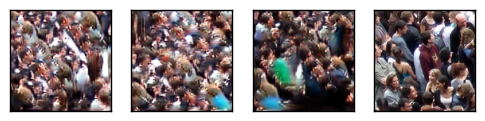

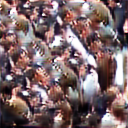

In [9]:
%matplotlib inline
def generate_sample():
    textures, real = session.run([synthetic_textures, real_textures])
    imshow_multi(list(np.clip(textures[:3], 0, 1)) + list(real[:1]))
    return to_pil(textures[0])
generate_sample()


In [ ]:
%matplotlib inline
imshow_multi(old_fakes_[:5])

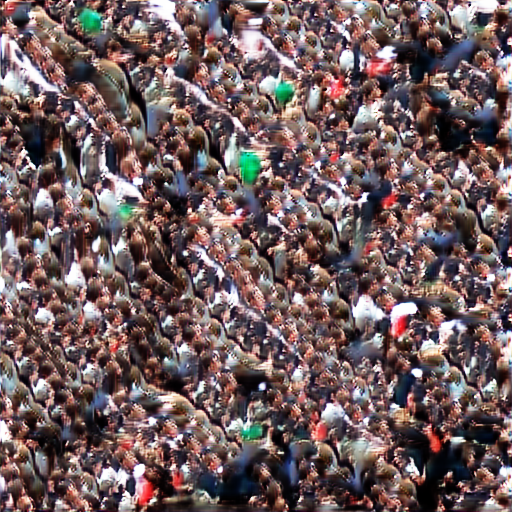

In [8]:
%matplotlib inline
def generate_large():
    sample = session.run(large_sample[0])
    return to_pil(sample)
generate_large()


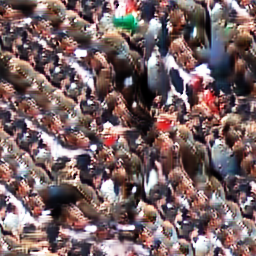

In [10]:
%matplotlib inline

def create_repeating():
    sample = session.run(repeating_sample[0])
    w,h = sample.shape[:2]
    sample = sample[int(w*0.25):int(w*0.75), int(h*0.25):int(h*0.75),:]
    return to_pil(sample)
create_repeating()